# Employee Retention Problem Goal: 

* Predict when employees are going to quit by understanding the main drivers of employee churn.
* What are the main factors that drive employee churn? Do they make sense? Explain your findings.
* What might you be able to do for the company to address employee Churn, what would be follow-up actions?
* If you could add to this data set just one variable that could help explain employee churn, what would that be?


## Solution

**Takeaways: **
The company needs to focus on a range of factors to increase employee retention. A generalized solution cannot be applied to all departments or companies. 


Observation on who quits more:
* Employees in 50K to 200K within 1-2 years of employments and more than 5 years of seniority quit more.
* Employees in customer service, marketing and sales with salaries lower than 200K  
* Employees in Data science and Engineering with salaries in 150K- 250K 
* Company 12 in speciifc, has trouble with low salories and more quitting

For predicting which employees quit, Running a random forest classifier on the the final data, adjusting for overfitting gives an accuracy of 0.80

Recommendations:
Employees stay longer who are paid more with higher experience in high paying jobs and those with lower salaries  and high expereicne in non high paying jobs. People in between leave the most. In order to tackle employee churn, its needed that the focus is on a strategy to increasy slary with increasing expereince, could also be in terms of bonuses based on performance. Tailoring bonues and salary increase to department can control employee churn in these cases.

Next:
- More data needed on:
    - average hours worked per week. 
    - date an employee received a raise/promotion
    - Bonuses and persformances received  and their dates
- Using other models like XGBoost or techniques like Survival analysis would also be better here .

With all this a more sophisticated salary- employee relationship could be understood and better strategies to overcome employee chrun



 



## Table of contents:
1. [Loadinf Data](#dataloading)  

2. [EDA](#eda)  
     
      a. [Number of employees who have quit so far](#NoEmp)  
      b. [Effect of salary on quitting ](# Quitting Vs salary)  
      c. [Effect of years worked on quitting ](#Quitting Vs years)  
      d. [Effect of Seniority on quitting](#Quitting Vs Seniority)  
      e. [Effect of department on quitting](# quitting vs department)  
      f. [Distribution of dept,salary and quitting](#dept and sal)
      g. [Distribution of company ,salary and quitting](#comp and sal)  
      

3. [Predicting who quits by creating a random forest model](#WhoQuits)
   
   a. [Creating Final data](#Creating Final data)
    
   b. [Prediction and Metrics](#model and metrics)
    
    
[Conclusion](#conclusion)

## Import libraries 

In [1]:
# Python imports
import itertools

# Data imports
import pandas as pd
import numpy as np
import seaborn as sns

# Viz imports
import matplotlib.pyplot as plt
%matplotlib inline

## Load data  <a name='dataloading'></a>

In [55]:
df = pd.read_csv('employee_retention_data.csv')

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


## EDA <a name='eda'></a>

** Checking for unique employees and other columns **

so there is no repetition in number of employees

In [6]:
print(len(df))
print('Unique employee id ', df['employee_id'].nunique())
print('Unique depts ',df['dept'].nunique())
print('Unique salary ',df['salary'].nunique())
print('Unique seniority',df['seniority'].nunique())
print('Unique company id ',df['company_id'].nunique())

24702
Unique employee id  24702
Unique depts  6
Unique salary  367
Unique seniority 31
Unique company id  12


** Checkinf for null values **

Only quit date column has null values. This corresponds to number of emplyees who have not quit

In [7]:
# Looking for null values in the data
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

** Number of employees who have quit so far **  <a name='#NoEmp'></a>

Looks like more people have quit

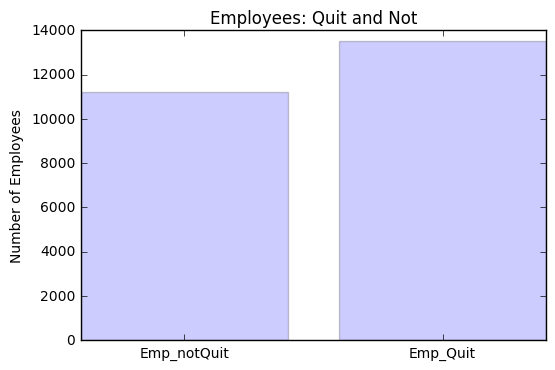

In [56]:
Emp_notQuit=df['quit_date'].isnull().sum()
Emp_Quit= df['employee_id'].count()-Emp_notQuit
# print('Number of employees who have not quit: %d' %Emp_notQuit)
# print('Number of employees who have quit: %d' %Emp_Quit)
labels = ('Emp_notQuit','Emp_Quit')
index = np.arange(len(labels))
plt.bar(index, [Emp_notQuit,Emp_Quit], align='center', alpha=0.2)
plt.xticks(index, labels)
plt.ylabel('Number of Employees')
plt.title('Employees: Quit and Not')
plt.show()
 

** Creating Quit Column  and days emplyed based on start and join dates **

** 1)  Creating quit column based on NA value in quit_date **

In [57]:
df['Not_quit']=df['quit_date'].isnull().astype(int)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


** 2) Converting start date and end date into years **

In [94]:
data_end_date = '2015-12-13'
df['quit_date'] = df['quit_date'].fillna(data_end_date)


In [98]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])
NumDays=(df['quit_date'].subtract(df['join_date'])).dt.days
df['years_worked']=NumDays/365 
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit,years_worked
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,1.602740
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,0.931507
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,1,1.167123
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,1.065753
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2.849315


** Distribution of Quitting Vs salary ** <a name=' Quitting Vs salary'></a>

Here we see that more employees in 100K to 200K salary range quit more 

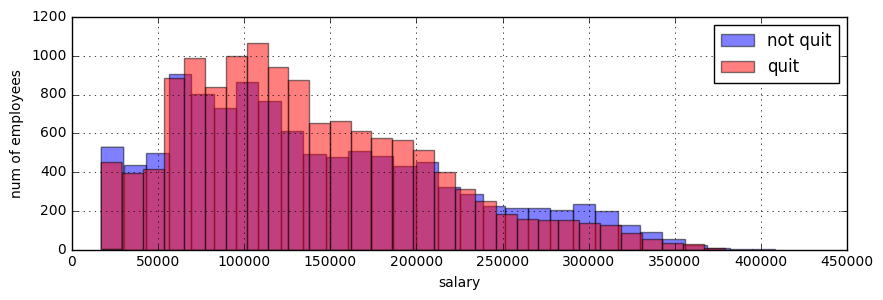

In [176]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['salary'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['salary'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('salary')
plt.ylabel('num of employees')
plt.show()

** Distribution of Quitting Vs years worked **  <a name=' Quitting Vs years'></a>


Here we see that more employees in 1-2 year range quit more 

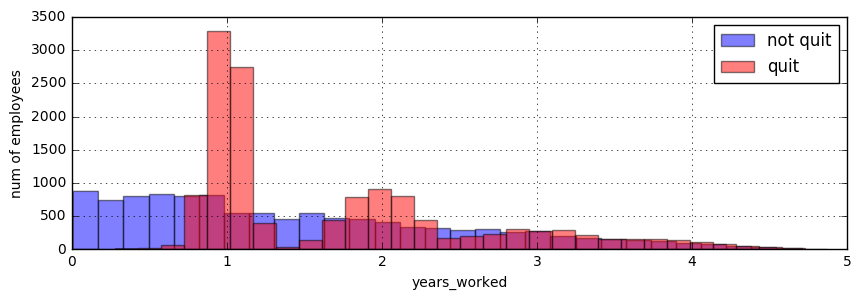

In [178]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['years_worked'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['years_worked'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('years_worked')
plt.ylabel('num of employees')
plt.show()

** Distribution of Quitting Vs Seniority **   <a name='Quitting Vs Seniority'></a>


** 1) Here we see seniority has some outliers **

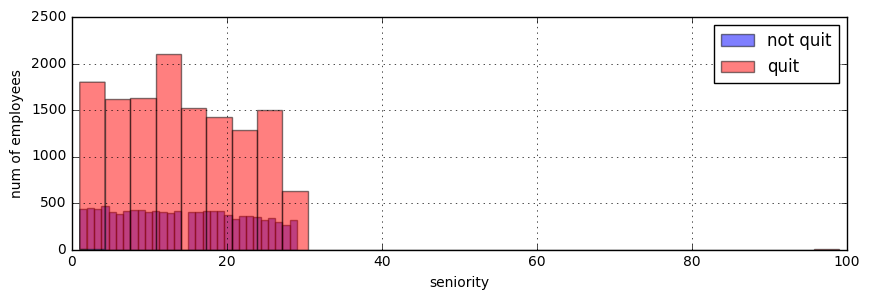

In [179]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['seniority'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['seniority'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('seniority')
plt.ylabel('num of employees')
plt.show()

** 2) Impute the Seniority coloumn outliers with median **

In [180]:
# mark zero values as missing or NaN
df['seniority']=df['seniority'].replace(df[(df['seniority']>30)]['seniority'], np.NaN)
# fill missing values with mean column values
df['seniority'].fillna(df['seniority'].median(), inplace=True)
# count the number of NaN values in each column
print(df['seniority'].isnull().sum())

0


**  3) Distribution of qutting vs seniority again **

Here we see that people with more than 5 years of seniority quit more

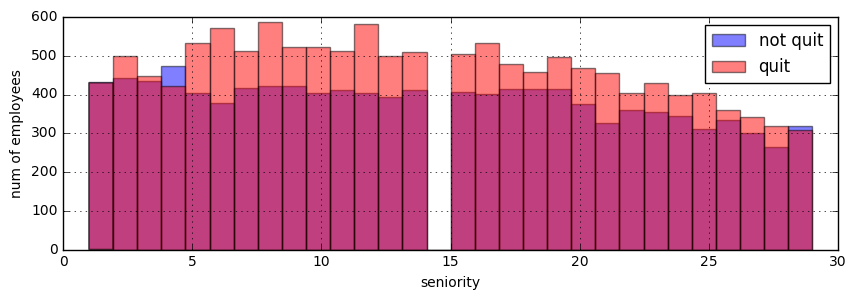

In [182]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['seniority'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['seniority'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('seniority')
plt.ylabel('num of employees')
plt.show()

**  Distribution of  quitting vs department **  <a name=' quitting vs department'></a>


Here we see that employees in customer service, marketing and sales are quitting more

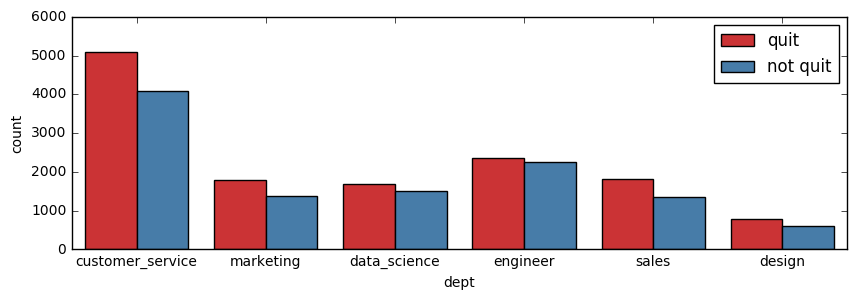

In [185]:
plt.figure(figsize=(10,3))
sns.countplot(x='dept',hue='Not_quit',data=df,palette='Set1')
plt.legend(('quit', 'not quit'))
plt.show()

** Distribution of dept vs salary and quitting **  <a name='dept and sal'></a>


Here we see that employees in customer service, marketing and sales are quitting more as they have salaries lower than 200K
Data scenie and engineers quit more int he salary range of 150K- 250K

C:\Users\PG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


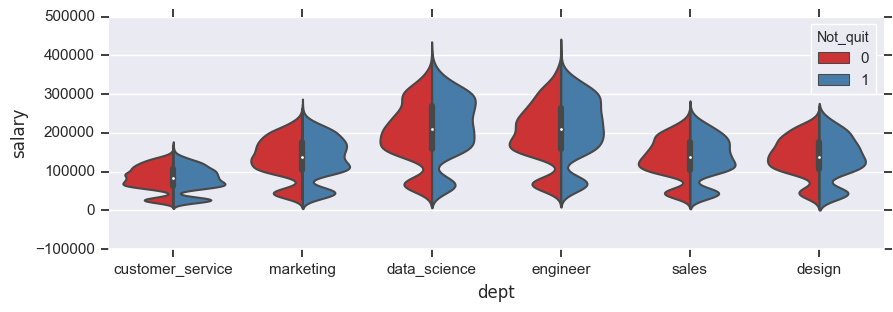

In [190]:
plt.figure(figsize=(10,3))

quit = (df.Not_quit == 0)
not_quit = (df.Not_quit == 1)

sns.set(palette="Set1")
sns.violinplot(x="dept", y="salary", hue="Not_quit",split=True,data=df)
sns.despine(left=True)
# plt.legend(('quit', 'not quit'))

plt.show()

**  Distribution of  quitting vs company ID **

Just shows that employees are quitting in all companies

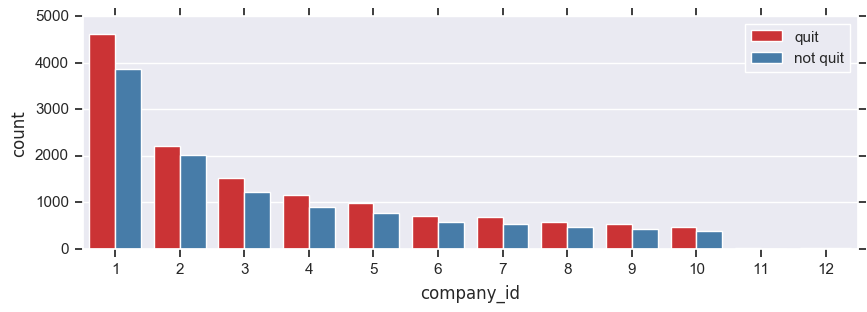

In [191]:
plt.figure(figsize=(10,3))
sns.countplot(x='company_id',hue='Not_quit',data=df,palette='Set1')
plt.legend(('quit', 'not quit'))
plt.show()

** Distribution  of company id vs salary and quitting **  <a name='comp and sal'></a>

All companies have more quitting for employees between the 50k-200k range. 
Here we see that employees in company 12 is in trouble with low salaraiesa and more quitting


C:\Users\PG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


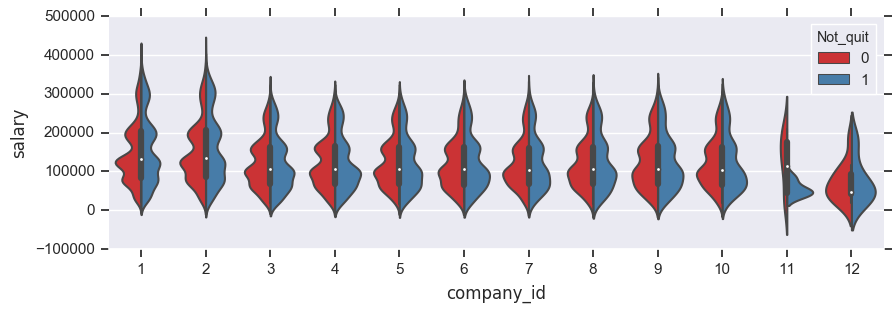

In [193]:
plt.figure(figsize=(10,3))
quit = (df.Not_quit == 0)
not_quit = (df.Not_quit == 1)

sns.set(palette="Set1")
sns.violinplot(x="company_id", y="salary", hue="Not_quit",split=True,data=df)
sns.despine(left=True)
plt.show()

## Creating a RF model to predict which employees  quit based on: company_id,	seniority,	salary,	years_worked,	dept_code  <a name='WhoQuits'></a>

## STEP 1 Creating Final data  <a name='Creating Final data'></a>



** 1)  changing dept category variables to integers using code for each department **

In [194]:
df.dept = pd.Categorical(df.dept)
# Now the data look similar but are stored categorically. To capture the category codes:
df['dept_code'] = df.dept.cat.codes
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit,years_worked,dept_code
0,13021.0,7,customer_service,28.0,89000.0,2014-03-24,2015-10-30,0,1.602740,0
1,825355.0,7,marketing,20.0,183000.0,2013-04-29,2014-04-04,0,0.931507,4
2,927315.0,4,marketing,14.0,101000.0,2014-10-13,2015-12-13,1,1.167123,4
3,662910.0,7,customer_service,20.0,115000.0,2012-05-14,2013-06-07,0,1.065753,0
4,256971.0,2,data_science,23.0,276000.0,2011-10-17,2014-08-22,0,2.849315,1


** 2) removing columns that we dont need **

In [195]:
# df.pop('quit_date')
# df.pop('join_date')
# df.pop('employee_id')
# df.pop('dept')

df = df.drop(columns = ['employee_id', 'join_date', 'quit_date', 'dept'])

df.head()

,company_id,seniority,salary,Not_quit,years_worked,dept_code
0,7,28.0,89000.0,0,1.602740,0
1,7,20.0,183000.0,0,0.931507,4
2,4,14.0,101000.0,1,1.167123,4
3,7,20.0,115000.0,0,1.065753,0
4,2,23.0,276000.0,0,2.849315,1


In [196]:
final_data=df

** 3) test train split **

In [290]:
import sklearn
from sklearn.model_selection import train_test_split

X = final_data.drop('Not_quit',axis=1)
y = final_data['Not_quit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=1234)

print(y_train.head())
X.head()

13383    0
1096     0
20033    0
604      1
14972    0
Name: Not_quit, dtype: int32


,company_id,seniority,salary,years_worked,dept_code
0,7,28.0,89000.0,1.602740,0
1,7,20.0,183000.0,0.931507,4
2,4,14.0,101000.0,1.167123,4
3,7,20.0,115000.0,1.065753,0
4,2,23.0,276000.0,2.849315,1


## STEP 2 Training the Random Forest model  <a name='model and metrics'></a>

In [291]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier



**1) Checking  Accuracy On testing and training data **

In [299]:
rfc = RandomForestClassifier()
rfc.fit(X_train,list(y_train.values))

print('Training accuracy: %.3f'%(accuracy_score(list(y_train.values),rfc.predict(X_train))))
print('Testing accuracy_score: %.3f'%(accuracy_score(list(y_test.values),rfc.predict(X_test))))
cm=confusion_matrix(list(y_test.values),rfc.predict(X_test))
cm=(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm


C:\Users\PG\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy: 0.984
Testing accuracy_score: 0.745


array([[0.84386617, 0.15613383],
       [0.37405598, 0.62594402]])

** 2) Feature Importances**   

The most important feature is the years worked at the company and salary



In [269]:
fea_imp = pd.DataFrame(
    rfc.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

fea_imp

,importance
years_worked,0.586776
salary,0.198708
seniority,0.115841
company_id,0.067444
dept_code,0.031231


** Applying the metrics on the training and test set, we see that ther for train set the accuracy is 0.99 and for test set it is 0.74. So there exists some overfitting of data here  Looking at feature importance  we see that we can reduce number of features and try fitting again**

** 3) Reducing Overfitting: checking model if only top feature is used ** 

In [375]:
X_train.iloc[:,2:4].head()


,salary,years_worked
1066,52000.0,2.830137
1989,323000.0,3.846575
9676,103000.0,0.989041
18374,60000.0,0.994521
12920,286000.0,0.457534


In [382]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

newX_train=X_train.iloc[:,2:4]
newX_test=X_test.iloc[:,2:4]

rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(newX_train,list(y_train.values))

print('Training accuracy:',(accuracy_score(list(y_train.values),rfc.predict(newX_train))))
print('Testing accuracy_score:',(accuracy_score(list(y_test.values),rfc.predict(newX_test))))
cm=confusion_matrix(list(y_test.values),rfc.predict(newX_test))
cm=(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
print(cm)

predictions=rfc.predict(newX_test)


Training accuracy: 0.9952937604372248
Testing accuracy_score: 0.7974094312892127
[[0.84696859 0.15303141]
 [0.2641852  0.7358148 ]]


** Now overfitting has dropped with testing accuracy around 80%. Could try using other models. But this shows that employee churn is mainly determined by salary and years worked **


** 4) Classification report on On testing data **



In [383]:
predictions = rfc.predict(newX_test)
print('classification reports:',classification_report(list(y_test.values),predictions))


classification reports:               precision    recall  f1-score   support

           0       0.80      0.85      0.82      2738
           1       0.79      0.74      0.76      2203

   micro avg       0.80      0.80      0.80      4941
   macro avg       0.80      0.79      0.79      4941
weighted avg       0.80      0.80      0.80      4941



**  5) visualizing confusion_matrix**   


In [365]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Normalized confusion matrix
[[0.85244704 0.14755296]
 [0.25783023 0.74216977]]


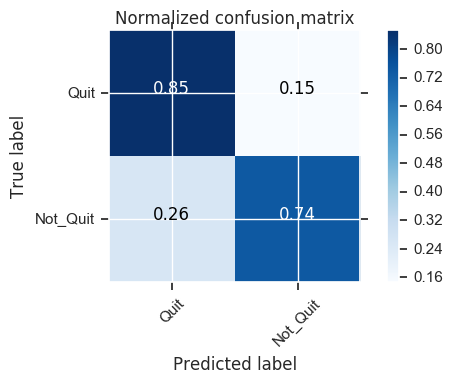

In [379]:
cnf_matrix = confusion_matrix(list(y_test.values),predictions)
class_names=  ['Quit','Not_Quit']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

** 6) ROC curves**   
In the ROC curve below with an AUC of 0.8, for TPR ~0.8 and FPR ~ 0.18 is theoperating point a company would choose to intervene  with strategy in keepingan employee.

In [380]:
def plot_roc(fpr, tpr, roc_auc):
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange',
             lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")

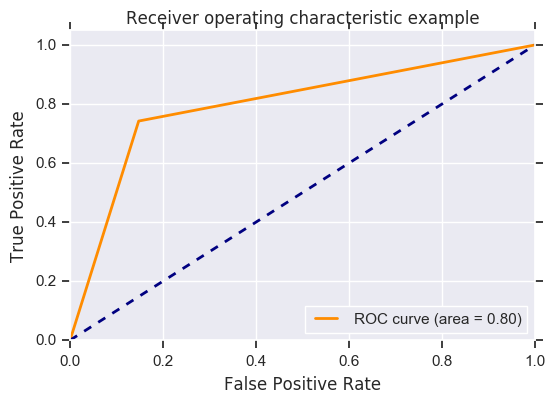

In [381]:
from sklearn.metrics import roc_curve, auc

plt.figure()
fpr, tpr, _ = roc_curve(list(y_test.values),predictions)
plot_roc(fpr, tpr, auc(fpr, tpr))
plt.show()

## Conclusion:  <a name='conclusion'></a>





Overall, the company needs to focus on a range of factors to increase employee retention. A generalized solution cannot be applied to all departments or companies. 
It is noticed that employees in 50K to 200K , within 1-2 years of employments, and more than 5 years of seniority quit more.
Employees in customer service, marketing and sales with salaries lower than 200K quit more 
Employees in Data scenie and Engineering with salaries in 150K- 250K quit more
Also, company 12 in speciifc, has trouble with low salories and more quitting

For predicting which employees  quit, Running a random forest classifier on the the final data, adjusting for overfitting gives an accuracy of 0.80

So we are able to determine who quits based on salary and years_worked,	department with more emphasis on salary, but we definitely need more  data to create a more robust model.Using other models like XGBoost or techniques like Survival analysis would also be better here .